In [3]:
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
load_dotenv(find_dotenv())

PROJECT_ROOT = Path(find_dotenv()).parent.resolve()
print(f"PROJECT_ROOT set to: {PROJECT_ROOT}")

DATA_DIR = PROJECT_ROOT / 'data'

PROJECT_ROOT set to: C:\Users\rtrin\OneDrive\Escritorio\FORMACIÓN\MÁSTER\TSCD\ProyectoTSCD


In [5]:
DATA_URL = "https://data.mendeley.com/public-files/datasets/b24cb4nn8h/files/94aa2cf6-b4c1-4140-bfcc-d21040a14735/file_downloaded"
FILE_PATH = DATA_DIR / "synthea_30k.csv"

DATA_DIR.mkdir(parents = True ,exist_ok = True )

if not FILE_PATH.exists():
    print("Descargando dataset...")
    response = requests.get(DATA_URL)
    with open(FILE_PATH, 'wb') as f:
        f.write(response.content)
    print("Descarga completada.")
else:
    print("Dataset ya disponible localmente.")

Dataset ya disponible localmente.


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, Embedding, ModuleList, Sequential, ReLU, Dropout, BatchNorm1d
from torch_geometric.nn import GATv2Conv, BatchNorm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import kneighbors_graph

# ==========================================
# 1. Carga y Detección de Tipos
# ==========================================
def load_and_preprocess_mixed():
    print(">>> Cargando datos...")
    df_train = pd.read_csv(DATA_DIR / 'datos_train.csv')
    df_test = pd.read_csv(DATA_DIR / 'datos_test.csv')
    
    # Unir temporalmente para preprocesamiento consistente
    df_train['is_train'] = 1
    df_test['is_train'] = 0
    df_all = pd.concat([df_train, df_test], ignore_index=True)
    
    # Rellenar nulos
    df_all = df_all.fillna(0)
    
    # Identificar columnas candidatas (las que empiezan por C-)
    candidate_cols = [c for c in df_train.columns if c.startswith('C-')]
    
    cat_cols = []
    num_cols = []
    
    # --- HEURÍSTICA DE DETECCIÓN ---
    # Si tiene pocos valores únicos (<20) -> Categórica
    # Si tiene muchos valores únicos (>=20) -> Numérica
    for col in candidate_cols:
        n_unique = df_all[col].nunique()
        if n_unique < 20: 
            cat_cols.append(col)
        else:
            num_cols.append(col)
            
    print(f"Detectadas: {len(num_cols)} Numéricas y {len(cat_cols)} Categóricas.")
    
    # --- Preprocesamiento Numérico (StandardScaler) ---
    scaler = StandardScaler()
    if num_cols:
        df_all[num_cols] = scaler.fit_transform(df_all[num_cols])
        x_num = torch.tensor(df_all[num_cols].values, dtype=torch.float)
    else:
        x_num = torch.zeros((len(df_all), 0)) # Placeholder
    
    # --- Preprocesamiento Categórico (LabelEncoder) ---
    cat_dims = []
    if cat_cols:
        for col in cat_cols:
            le = LabelEncoder()
            df_all[col] = le.fit_transform(df_all[col].astype(str))
            cat_dims.append(len(le.classes_))
        x_cat = torch.tensor(df_all[cat_cols].values, dtype=torch.long)
    else:
        x_cat = torch.zeros((len(df_all), 0), dtype=torch.long)
        
    # Target y Máscaras
    y = torch.tensor(df_all['target'].values, dtype=torch.long)
    train_mask = torch.tensor(df_all['is_train'] == 1, dtype=torch.bool)
    
    return x_num, x_cat, y, train_mask, cat_dims

# Ejecutar carga
x_num, x_cat, y, train_mask, cat_dims = load_and_preprocess_mixed()

# ==========================================
# 2. Construcción del Grafo (Metric Approach)
# ==========================================
print(">>> Construyendo Grafo (KNN)...")

# Para calcular distancias en el KNN, usamos una combinación de las features
# (Las categóricas ya codificadas se pueden tratar como numéricas para la distancia simple 
# o usar solo las numéricas reales. Usaremos todas para aprovechar toda la info).
features_metric = torch.cat([x_num, x_cat.float()], dim=1).numpy()

# KNN Graph
k = 5
adj = kneighbors_graph(features_metric, n_neighbors=k, mode='connectivity', include_self=False)
coo = adj.tocoo()
edge_index = torch.stack([torch.tensor(coo.row), torch.tensor(coo.col)], dim=0).long()

print(f"    Nodos: {x_num.shape[0]}")
print(f"    Aristas: {edge_index.shape[1]}")

# ==========================================
# 3. Modelo GNN Híbrido (Num + Cat)
# ==========================================
class TabularGNN(torch.nn.Module):
    def __init__(self, num_features, cat_dims, hidden_dim, out_dim, heads=2):
        super().__init__()
        
        # A. Rama Categórica (Embeddings)
        self.embeddings = ModuleList([
            Embedding(d, min(16, (d+1)//2)) for d in cat_dims
        ])
        cat_out_dim = sum([emb.embedding_dim for emb in self.embeddings])
        
        # B. Rama Numérica (Proyección Lineal)
        self.num_proj = Linear(num_features, hidden_dim)
        
        # Combinación (Cat Embeddings + Num Proj -> Hidden)
        # La entrada a la combinación es: (suma de dims de embeddings) + hidden_dim (de la numérica)
        self.lin_combine = Linear(cat_out_dim + hidden_dim, hidden_dim)
        
        # C. GNN Backbone (GAT)
        self.gnn1 = GATv2Conv(hidden_dim, hidden_dim, heads=heads, dropout=0.2)
        self.bn1 = BatchNorm(hidden_dim * heads)
        
        self.gnn2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=False, dropout=0.2)
        self.bn2 = BatchNorm(hidden_dim)
        
        # D. Clasificador
        self.classifier = Sequential(
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Linear(hidden_dim // 2, out_dim)
        )

    def forward(self, x_num, x_cat, edge_index):
        # 1. Procesar Categóricas
        emb_list = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat_enc = torch.cat(emb_list, dim=1)
        
        # 2. Procesar Numéricas
        x_num_enc = self.num_proj(x_num)
        x_num_enc = F.relu(x_num_enc)
        
        # 3. Fusionar
        x = torch.cat([x_cat_enc, x_num_enc], dim=1)
        x = self.lin_combine(x)
        x = F.relu(x)
        
        # 4. Grafo (Message Passing)
        x = self.gnn1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.gnn2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        
        return self.classifier(x)

# ==========================================
# 4. Entrenamiento
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TabularGNN(
    num_features=x_num.shape[1],
    cat_dims=cat_dims,
    hidden_dim=32,
    out_dim=2
).to(device)

x_num, x_cat = x_num.to(device), x_cat.to(device)
y, edge_index = y.to(device), edge_index.to(device)
train_mask = train_mask.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

print(">>> Iniciando entrenamiento...")
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    
    out = model(x_num, x_cat, edge_index)
    loss = criterion(out[train_mask], y[train_mask])
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = (pred[train_mask] == y[train_mask]).float().mean()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {acc:.4f}')

>>> Cargando datos...
Detectadas: 9 Numéricas y 41 Categóricas.
>>> Construyendo Grafo (KNN)...


c:\Users\rtrin\OneDrive\Escritorio\FORMACIÓN\MÁSTER\TSCD\ProyectoTSCD\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


    Nodos: 4221
    Aristas: 21105
>>> Iniciando entrenamiento...
Epoch: 010, Loss: 0.3644, Train Acc: 0.8750
Epoch: 020, Loss: 0.2351, Train Acc: 0.9105
Epoch: 030, Loss: 0.2152, Train Acc: 0.9144
Epoch: 040, Loss: 0.2055, Train Acc: 0.9180
Epoch: 050, Loss: 0.1950, Train Acc: 0.9221
Epoch: 060, Loss: 0.1851, Train Acc: 0.9239
Epoch: 070, Loss: 0.1796, Train Acc: 0.9283
Epoch: 080, Loss: 0.1755, Train Acc: 0.9313
Epoch: 090, Loss: 0.1647, Train Acc: 0.9334
Epoch: 100, Loss: 0.1630, Train Acc: 0.9348



>>> Evaluando modelo en conjunto de TEST...

--- Resultados Finales en Test ---
Accuracy : 0.9136
F1 Score : 0.9122
AUC-ROC  : 0.9682

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       613
           1       0.88      0.79      0.83       232

    accuracy                           0.91       845
   macro avg       0.90      0.88      0.89       845
weighted avg       0.91      0.91      0.91       845



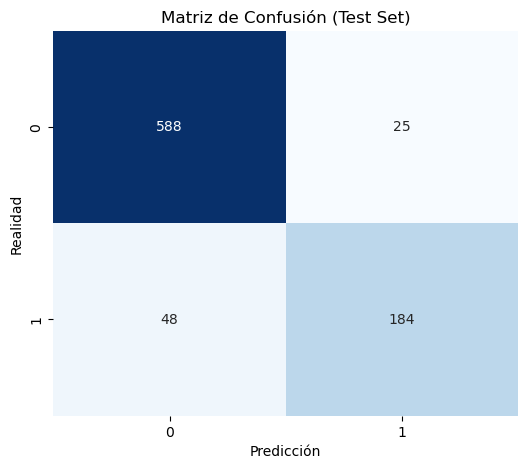

NameError: name 'df_test' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("\n>>> Evaluando modelo en conjunto de TEST...")

model.eval()
with torch.no_grad():
    # 1. Forward pass completo
    out = model(x_num, x_cat, edge_index)
    
    # 2. Obtener probabilidades y predicciones
    probs = F.softmax(out, dim=1)[:, 1]  # Probabilidad de clase 1
    preds = out.argmax(dim=1)            # Predicción dura (0 o 1)
    
    # 3. Filtrar solo los nodos de TEST
    # Usamos la negación de la máscara de entrenamiento (~train_mask)
    y_test_true = y[~train_mask].cpu().numpy()
    y_test_prob = probs[~train_mask].cpu().numpy()
    y_test_pred = preds[~train_mask].cpu().numpy()

# --- Cálculo de Métricas ---
acc = accuracy_score(y_test_true, y_test_pred)
f1 = f1_score(y_test_true, y_test_pred, average='weighted')
try:
    auc = roc_auc_score(y_test_true, y_test_prob)
except ValueError:
    auc = 0.0 # Manejo de error si solo hay una clase en test

print(f"\n--- Resultados Finales en Test ---")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")

print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test_true, y_test_pred))

# --- Matriz de Confusión ---
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión (Test Set)')
plt.show()

